In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Set the dataset path
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Cholesteatoma/dataset/augmented_updated'

# Check if GPU is available
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found. Using CPU.')
else:
    print(f'Found GPU at: {device_name}')

# Set parameters
img_size = (224, 224)  # MobileNetV2 input size
batch_size = 32

# Data Augmentation and Loading
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

# Training data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the base MobileNetV2 model with ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 3 classes

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Define callbacks
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Change file extension to .keras
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

# Save the final model
model.save('/content/drive/MyDrive/Colab Notebooks/Cholesteatoma/mobilenetv2.h5')


Found GPU at: /device:GPU:0


Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/50 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.3235 - loss: 1.7943 
Epoch 1: val_accuracy improved from -inf to 0.54250, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 396s 7s/step - accuracy: 0.3255 - loss: 1.7828 - val_accuracy: 0.5425 - val_loss: 1.1635
Epoch 2/20
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.4501 - loss: 1.2020
Epoch 2: val_accuracy improved from 0.54250 to 0.64750, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 539ms/step - accuracy: 0.4506 - loss: 1.2012 - val_accuracy: 0.6475 - val_loss: 0.9848
Epoch 3/20
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.5062 - loss: 1.0944
Epoch 3: val_accuracy improved from 0.64750 to 0.68750, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 537ms/step - accuracy: 0.5073 - loss: 1.0931 - val_accuracy: 0.6875 - val_loss: 0.9219
Epoch 4/20
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.5774 - loss: 1.0066
Epoch 4: val_accuracy did not improve from 0.68750
50

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 510ms/step - accuracy: 0.7857 - loss: 0.6400
Validation Loss: 0.6662
Validation Accuracy: 0.7750


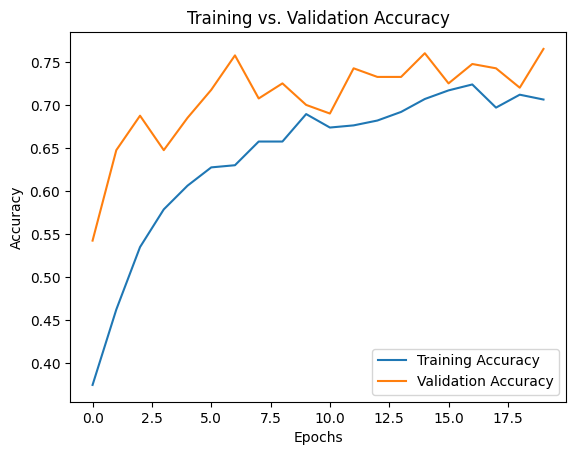

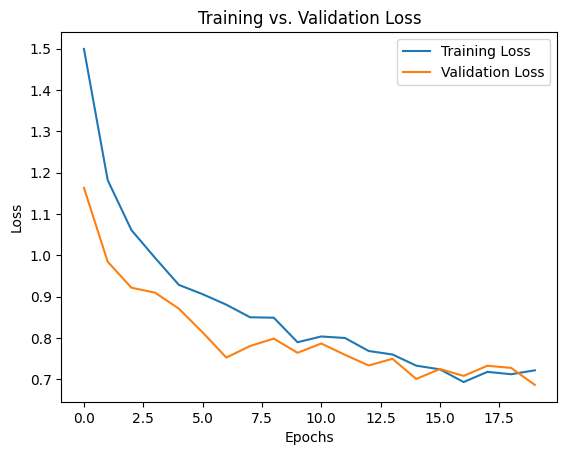